<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
code = '005930'
start_date = '20210922'

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import ast

class Stock:
  def __init__(self, code):
    self.code = code
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_price(self, start:int='20180501', interval='day'):
    url ='https://api.finance.naver.com/siseJson.naver?symbol=' + self.code + '&requestType=1&startTime=' \
    + start + '&endTime=' + str(datetime.datetime.now().date().strftime("%Y%m%d")) + '&timeframe=' + interval


    result = requests.get(url)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    b = bs_obj.get_text()
    for i in ['\n', '\t', "\\", ' ']:
      b = b.replace(i,'')

    data = np.array(ast.literal_eval(b)[1:])

    dic = {'Date':list(map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'), data[:,0])), \
      'Open':np.array(data[:,1], float), 'High':np.array(data[:,2], float), 'Low':np.array(data[:,3], float),\
       'Close':np.array(data[:,4], float), 'Volume':np.array(data[:,5], float)}

    df = pd.DataFrame(data=dic)
    df = df.set_index('Date')
    return df
    
  def get_fundamental(self):
    url = 'https://finance.naver.com/item/main.nhn?code=' + self.code
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    ths = bs_obj.find_all("th", {'scope':'col'})
    ths = [th.get_text() for th in ths][10:-22]
    dates = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),ths))
    dates = list(map(lambda x: x + '(Y)', dates[:4])) + list(map(lambda x: x + '(M)', dates[4:]))

    tr = bs_obj.find_all("tbody")
    tds = tr[2].find_all('td')
    tds = [td.get_text() for td in tds]
    elements = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),tds))
    elements = list(map(lambda x: float(x) if x.replace('.','').isdigit() else np.nan, elements))

    temp_dict = {}
    cnt = 0
    index = ['sales', 'operating profit', 'net income', 'operating margin', 'net margin', 'roe', 'debt ratio', 'quick ratio', \
    'reserve ratio', 'eps', 'per', 'bps', 'pbr', 'dividend per share', 'dividend yield ratio', 'dividend payout ratio']

    for i in dates:
      temp_dict[i] = elements[cnt::10]
      cnt += 1

    df = pd.DataFrame.from_dict(temp_dict)
    df = df.set_index([pd.Index(index)])
    return df

In [3]:
stock = Stock(code)

In [4]:
price_df = stock.get_price(start_date)
price_df['Change'] = price_df['Close'][1:]/price_df['Close'][:-1].values
price_df = price_df[1:]
price_df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-09-24,77600.0,77700.0,77100.0,77300.0,12247274.0,0.998708
2021-09-27,77300.0,77700.0,77000.0,77700.0,11699798.0,1.005175
2021-09-28,77700.0,77800.0,76200.0,76300.0,15406382.0,0.981982
2021-09-29,74800.0,75300.0,73800.0,74100.0,23992458.0,0.971166
2021-09-30,74300.0,74800.0,73700.0,74100.0,19919361.0,1.000000
...,...,...,...,...,...,...
2022-09-16,55600.0,56400.0,55500.0,56200.0,13456503.0,1.003571
2022-09-19,56300.0,57000.0,56000.0,56400.0,12278653.0,1.003559
2022-09-20,56400.0,57000.0,55800.0,55800.0,14041465.0,0.989362


In [5]:
index_df = Stock('KOSPI')
index_df = index_df.get_price('20000101')
index_df['Change'] = index_df['Close'][1:]/index_df['Close'][:-1].values
index_df = index_df[1:]

# 주식 액면분할 날짜 제거
index_df = index_df.drop(index=index_df.index.difference(price_df.index))

In [6]:
stock_return = price_df['Change'].mean()
stock_return_std = price_df['Change'].std()
risk_free = 1.025**(1/250) # risk-free rate

sharpe_ratio = (stock_return - risk_free)/stock_return_std
sharpe_ratio

-0.10714507180683773

In [7]:
import numpy as np

cov = np.cov(np.array(price_df['Change']), np.array(index_df['Change']))[0][1]
market_variance =  index_df['Change'].var()
beta = cov/market_variance

treynor_ratio = (stock_return - risk_free)/beta
treynor_ratio

-0.0015361168673812679

In [8]:
risk_free_min = risk_free
downside_std = price_df[price_df['Change'] < 1]['Change'].std()

sortino_ratio = (stock_return - risk_free_min)/downside_std
sortino_ratio

-0.20771986035791679

In [9]:
market_return = index_df['Change'].mean()

jensens_alpha = stock_return - (risk_free + beta*(market_return - risk_free))
jensens_alpha

-0.00028708020848700055

In [10]:
benchmark_return = market_return
tracking_error = (sum((price_df['Change']-index_df['Change'])**2)/(len(price_df.index)-1))**(1/2)

information_ratio = (stock_return - benchmark_return)/tracking_error
information_ratio

-0.024449093900839512

In [11]:
fundamental_df = stock.get_fundamental()
fundamental_df

,2019.12(Y),2020.12(Y),2021.12(Y),2022.12(E)(Y),2021.06(M),2021.09(M),2021.12(M),2022.03(M),2022.06(M),2022.09(E)(M)
sales,2304009.00,2368070.00,2796048.00,3136985.00,636716.00,739792.00,765655.00,777815.00,772036.00,789910.00
operating profit,277685.00,359939.00,516339.00,524190.00,125667.00,158175.00,138667.00,141214.00,140970.00,128550.00
net income,217389.00,264078.00,399074.00,412037.00,96345.00,122933.00,108379.00,113246.00,110988.00,106360.00
operating margin,12.05,15.20,18.47,16.71,19.74,21.38,18.11,18.15,18.26,16.27
net margin,9.44,11.15,14.27,13.13,15.13,16.62,14.16,14.56,14.38,13.46
roe,8.69,9.98,13.92,12.94,12.04,12.60,13.92,15.13,15.10,NaN
debt ratio,34.12,37.07,39.92,NaN,36.29,38.30,39.92,39.34,36.64,NaN
quick ratio,233.57,214.82,196.75,NaN,214.08,210.70,196.75,202.26,219.39,NaN
reserve ratio,28856.02,30692.79,33143.62,NaN,31140.36,32225.78,33143.62,34110.56,35054.68,NaN
eps,3166.00,3841.00,5777.00,5967.00,1391.00,1775.00,1567.00,1638.00,1613.00,1364.00


In [12]:
from dateutil import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt

class Analyser:
  def __init__(self, price_df, fundamental_df):
    self.price_df = price_df
    self.fundamental_df = fundamental_df
    self.mixed_df = self.get_mixed_df()

  def find_date(self, year, month):
    # 결산일 고려 (2달)
    year,month = int(year), int(month)
    next = datetime.date(year,month,1) + relativedelta.relativedelta(months=2)
    year, month = next.year, next.month

    start = str(year) + '-' + str(month) + '-' + '01'
    end = str(year) + '-' + str(month) + '-' + '20'
    return self.price_df.loc[start:end].index.values[0]

  def get_mixed_df(self):
    price_dic = {}
    cnt = 0
    for i in [(x[:4], x[5:7]) for x in self.fundamental_df.columns.values]:
      try:
        price_dic[self.fundamental_df.columns.values[cnt]] = price_df.loc[self.find_date(i[0],i[1])]['Close']
      except:
        price_dic[self.fundamental_df.columns.values[cnt]] = 0
      cnt+=1
    return self.fundamental_df.append(pd.DataFrame(data=price_dic,  index = ['Price']))

  def get_heatmap(self):
    # correlation heatmap
    corrmat = self.mixed_df.transpose().corr().abs() 
    plt.subplots(figsize=(12,12))
    sns.heatmap(corrmat, annot = True)

  def get_influential(self, num=6):
    return self.get_mixed_df().transpose().corr()['Price'].sort_values(ascending = False).head(num)

In [13]:
analyser = Analyser(price_df, fundamental_df)

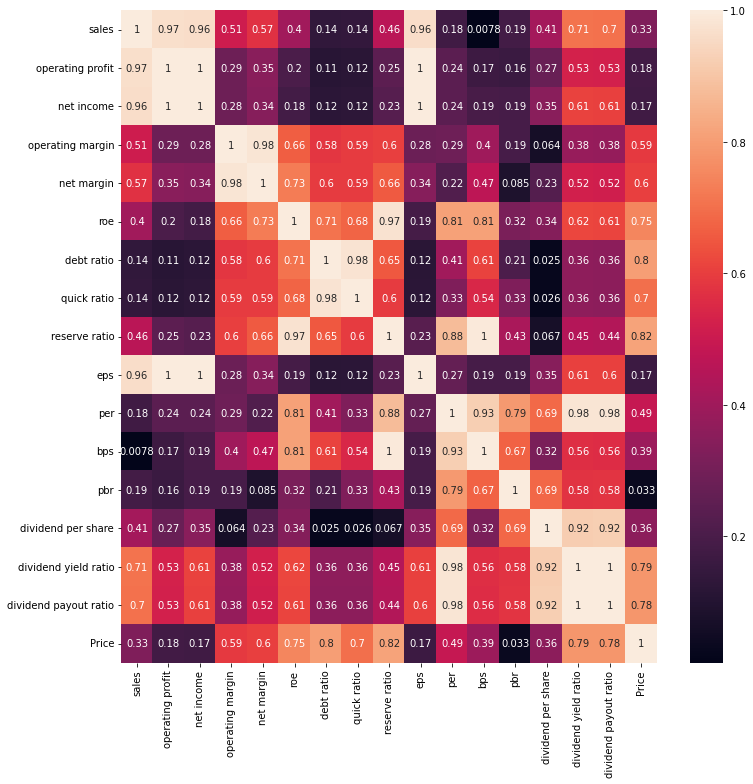

In [14]:
analyser.get_heatmap()

In [15]:
analyser.get_influential()[1:]

reserve ratio       0.815270
debt ratio          0.803355
roe                 0.749878
net margin          0.602671
operating margin    0.591800
Name: Price, dtype: float64

fundamental growth